# Assessing finetuning impact on Cobol repository 

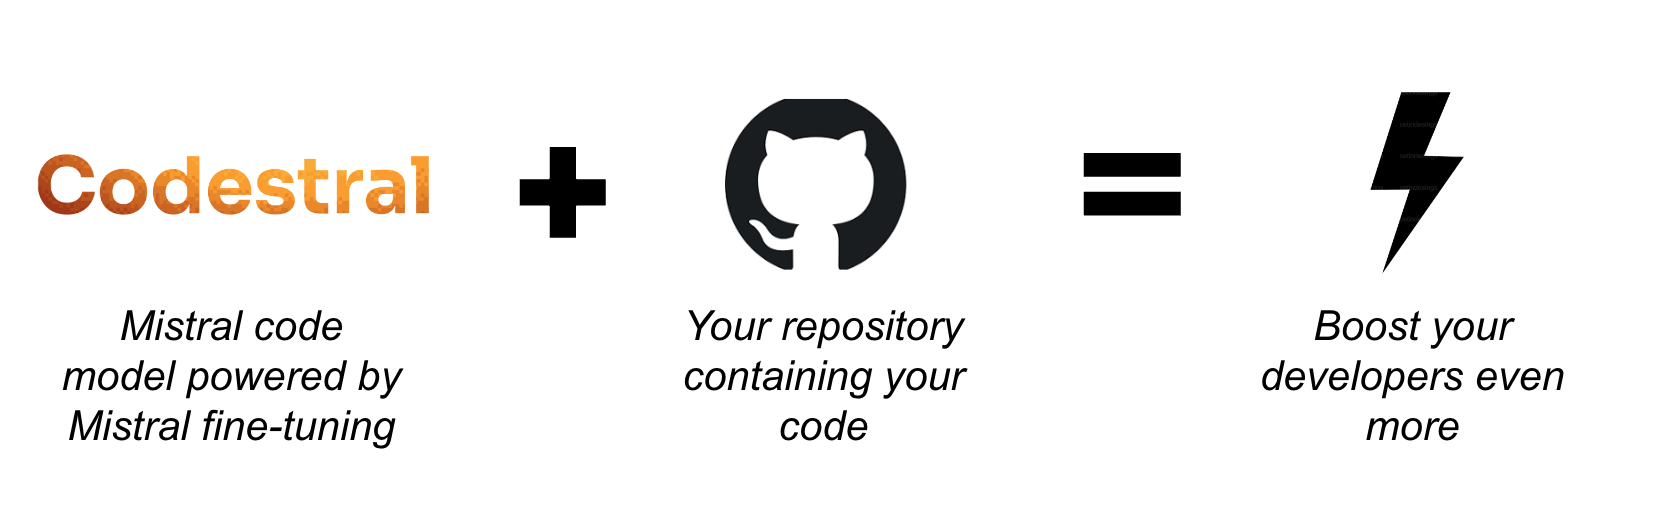

## Import needed packages

The first step is to install the needed packages `mistralai` and import the needed packages : 

In [1]:
! pip install mistralai

In [3]:
from mistralai import Mistral
from getpass import getpass
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt

# Step 1 : Access Mistral client and get your Github token

To access programatically to a Github repo you want to finetune you must generate a github Fine-grained token. 
Generate your token in the `Settings/Developer Settings` of your Github profile. 

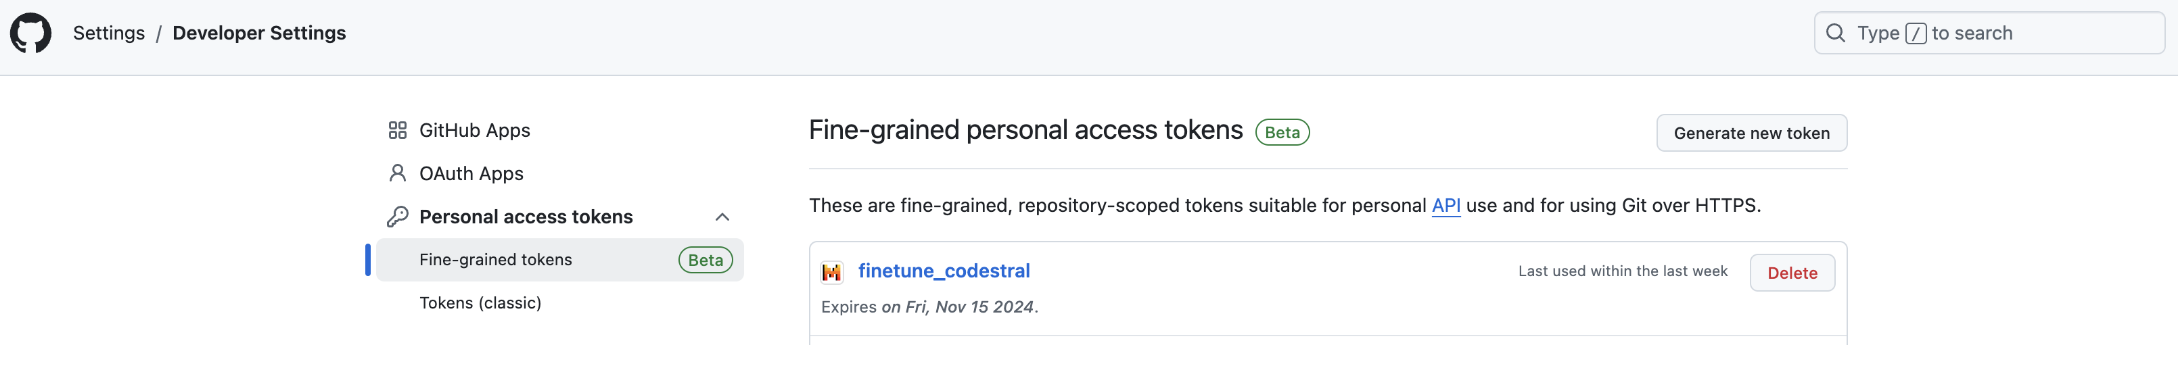

In [7]:
api_key= getpass("Type your API Key")
github_token =  getpass("Type your Github token")

client = Mistral(api_key=api_key)

# Step 2 : Finetune Codestral on a Cobol repository  

For the sake of this experiment we will be finetuning Codestral on an open-source [Cobol course](https://github.com/openmainframeproject/cobol-programming-course/tree/master/COBOL%20Programming%20Course%20%232%20-%20Learning%20COBOL) This repository is specialised in Cobol.
Finetuning a Codestral model on [Cobol course](https://github.com/openmainframeproject/cobol-programming-course/tree/master/COBOL%20Programming%20Course%20%232%20-%20Learning%20COBOL) is very straightforward.

In [8]:
created_jobs = client.fine_tuning.jobs.create(
    model="codestral-latest",
    auto_start=True,
    repositories=[
        {
            "type": "github",
            "owner": "openmainframeproject",
            "name": "cobol-programming-course",
            "token":github_token
        }
    ],
    hyperparameters={
        "training_steps": 50,
        "learning_rate":0.0001
    }
)

ft:codestral-latest:9fd0b0bc:20241120:fff88efd


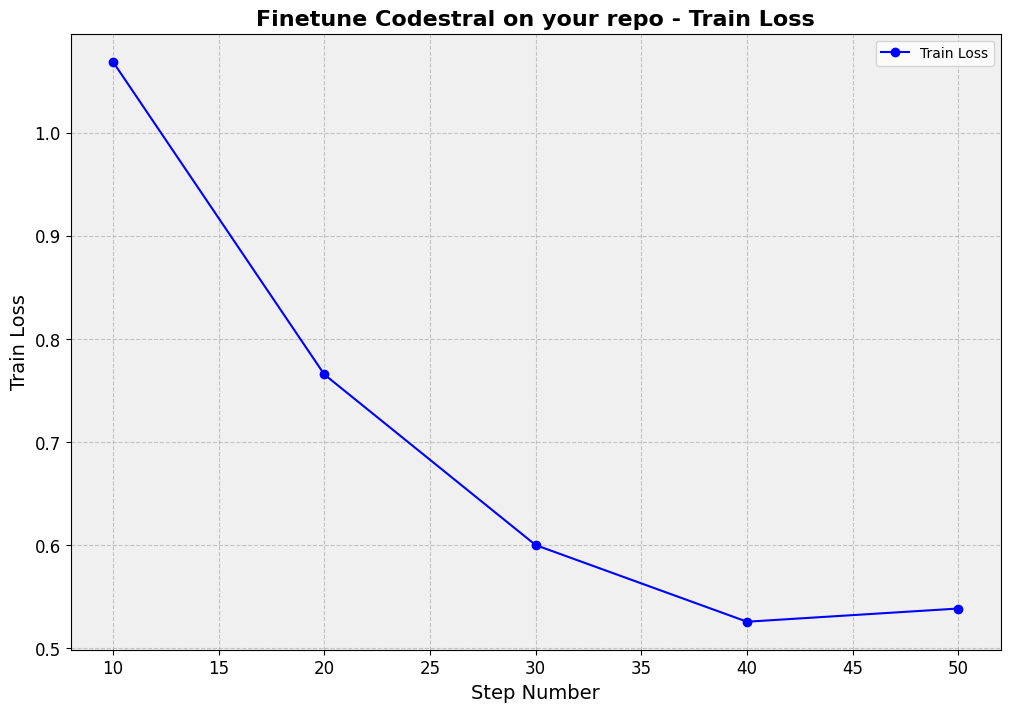

In [14]:
# Extract step_number and train_loss from the job data
retrieved_job = client.fine_tuning.jobs.get(job_id = created_jobs.id)
print(retrieved_job.fine_tuned_model)
step_numbers = [checkpoint.step_number for checkpoint in retrieved_job.checkpoints]
train_losses = [checkpoint.metrics.train_loss for checkpoint in retrieved_job.checkpoints]

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(step_numbers, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')

# Adding titles and labels
plt.title('Finetune Codestral on your repo - Train Loss', fontsize=16, fontweight='bold')
plt.xlabel('Step Number', fontsize=14)
plt.ylabel('Train Loss', fontsize=14)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(loc='best')

# Customizing the appearance
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a background color
plt.gca().set_facecolor('#f0f0f0')

# Display the plot
plt.show()

# Step 3 : Model Performance Evaluation

The logic of evaluation in this code is based on next line accuracy between the model's generated suggestion and the actual answer.

Our goal is to evaluate the performance of two models: Codestral and Codestral finetuned on a COBOL repository. The performances are tested on three different files to assess the models' capabilities and potential overfitting. The files used for testing are:

1. **COBOL File from Finetuned Repo**: This file is taken from the repository on which Codestral was finetuned.
2. **New COBOL File**: A new file that is not taken from the repository on which Codestral was finetuned.
3. **Testimony Python File**: A Python file that the models have not seen before, providing a measure of the models' ability to generalize to a different programming language.

### Step 3.1 Format evaluation dataset 

In [15]:
def generate_fim_sample(sample, rng):
    """
    Generate a FIM sample from a code sample.
    """
    # Split lines and remove empty lines
    lines = [line for line in sample.split("\n") if line.strip() != ""]
    reduced_sample = "\n".join(lines)
    assert len(lines) >= 2, f"{len(lines)} {sample}"

    # Randomly select a line
    line = rng.integers(1, len(lines))
    assert 1 <= line < len(lines), f"{line} {len(lines)}"

    # Prefix, suffix, answer
    prefix = "\n".join(lines[:line]) + "\n"
    answer = lines[line]
    suffix = "\n".join(lines[line + 1:])

    if len(suffix) > 0:
        answer += "\n"

    assert (len(suffix) == 0) or (suffix[0] != "\n"), f"{suffix}"
    assert (len(suffix) == 0) or answer.endswith("\n"), answer

    assert (
        prefix + answer + suffix == reduced_sample
    ), f"\nPrefix-Answer-Suffix\n{prefix}{answer}{suffix}\nSample\n{reduced_sample}"

    return prefix, suffix, answer

def generate_fim_examples(sample, max_num_examples, rng):
    """
    Generates deduplicated FIM examples.
    """
    # Generate a set of unique FIM samples
    deduplicated = {generate_fim_sample(sample, rng) for _ in range(max_num_examples)}

    # Convert the set of tuples to a list of dictionaries
    examples = [{"prefix": example[0], "answer": example[2], "suffix": example[1]} for example in deduplicated]

    return examples

In [16]:
KNOWN_COBOL_FILE="""
 *-----------------------
      * Copyright Contributors to the COBOL Programming Course
      * SPDX-License-Identifier: CC-BY-4.0
      *-----------------------
       IDENTIFICATION DIVISION.
      *-----------------------
       PROGRAM-ID.    CBLDB23
       AUTHOR.        Otto B. Relational

       ENVIRONMENT DIVISION.
      *--------------------
       CONFIGURATION SECTION.
       INPUT-OUTPUT SECTION.
       FILE-CONTROL.
           SELECT REPOUT
                  ASSIGN TO UT-S-REPORT.
           SELECT CARDIN
                  ASSIGN TO DA-S-CARDIN.

       DATA DIVISION.
      *-------------
       FILE SECTION.
       FD  REPOUT
               RECORD CONTAINS 120 CHARACTERS
               LABEL RECORDS ARE OMITTED
               RECORDING MODE F
               DATA RECORD IS REPREC.
       01  REPREC.
           05  ACCT-NO-O      PIC X(8).
           05  ACCT-LASTN-O   PIC X(20).
           05  ACCT-FIRSTN-O  PIC X(15).
           05  ACCT-ADDR3-O   PIC X(15).
       FD      CARDIN
               RECORD CONTAINS 80 CHARACTERS
               BLOCK CONTAINS 0 RECORDS
               RECORDING MODE F
               LABEL RECORDS ARE OMITTED.
       01  CARDREC                    PIC X(80).

       WORKING-STORAGE SECTION.
      *****************************************************
      * STRUCTURE FOR INPUT                               *
      *****************************************************
       01  IOAREA.
               02  STATE              PIC X(25).
               02  FILLER             PIC X(55).
       77  INPUT-SWITCH        PIC X          VALUE  'Y'.
               88  NOMORE-INPUT               VALUE  'N'.
      *****************************************************
      * SQL INCLUDE FOR SQLCA                             *
      *****************************************************
                EXEC SQL INCLUDE SQLCA  END-EXEC.
      *****************************************************
      * DECLARATIONS FOR SQL ERROR HANDLING               *
      *****************************************************
       01 ERROR-MESSAGE.
           02 ERROR-LEN      PIC S9(4)  COMP VALUE +1320.
           02 ERROR-TEXT     PIC X(132) OCCURS 10 TIMES
                                        INDEXED BY ERROR-INDEX.
       77 ERROR-TEXT-LEN     PIC S9(9)  COMP VALUE +132.
       77 ERROR-TEXT-HBOUND  PIC S9(9)  COMP VALUE +10.
      * USER DEFINED ERROR MESSAGE
       01 UD-ERROR-MESSAGE   PIC X(80)  VALUE SPACES.
      *****************************************************
      * SQL DECLARATION FOR VIEW ACCOUNTS                 *
      *****************************************************
                EXEC SQL DECLARE Z#####T TABLE
                        (ACCTNO     CHAR(8)  NOT NULL,
                         LIMIT      DECIMAL(9,2)     ,
                         BALANCE    DECIMAL(9,2)     ,
                         SURNAME    CHAR(20) NOT NULL,
                         FIRSTN     CHAR(15) NOT NULL,
                         ADDRESS1   CHAR(25) NOT NULL,
                         ADDRESS2   CHAR(20) NOT NULL,
                         ADDRESS3   CHAR(15) NOT NULL,
                         RESERVED   CHAR(7)  NOT NULL,
                         COMMENTS   CHAR(50) NOT NULL)
                         END-EXEC.
      *****************************************************
      * SQL CURSORS                                       *
      *****************************************************
                EXEC SQL DECLARE CUR1  CURSOR FOR
                         SELECT * FROM Z#####T
                     END-EXEC.
                EXEC SQL DECLARE CUR2  CURSOR FOR
                         SELECT *
                         FROM   Z#####T
                         WHERE  ADDRESS3 = :STATE
                      END-EXEC.
      *****************************************************
      * STRUCTURE FOR CUSTOMER RECORD                     *
      *****************************************************
       01 CUSTOMER-RECORD.
          02 ACCT-NO            PIC X(8).
          02 ACCT-LIMIT         PIC S9(7)V99 COMP-3.
          02 ACCT-BALANCE       PIC S9(7)V99 COMP-3.
          02 ACCT-LASTN         PIC X(20).
          02 ACCT-FIRSTN        PIC X(15).
          02 ACCT-ADDR1         PIC X(25).
          02 ACCT-ADDR2         PIC X(20).
          02 ACCT-ADDR3         PIC X(15).
          02 ACCT-RSRVD         PIC X(7).
          02 ACCT-COMMENT       PIC X(50).

       PROCEDURE DIVISION.
      *------------------
       PROG-START.
                OPEN INPUT  CARDIN.
                OPEN OUTPUT REPOUT.
                READ CARDIN RECORD INTO IOAREA
                   AT END SET NOMORE-INPUT TO TRUE.
                PERFORM PROCESS-INPUT
                   UNTIL NOMORE-INPUT.
       PROG-END.
                CLOSE CARDIN
                      REPOUT.
                GOBACK.
       PROCESS-INPUT.
                IF STATE = '*'
                   PERFORM GET-ALL
                ELSE
                   PERFORM GET-SPECIFIC.
                READ CARDIN RECORD INTO IOAREA
                   AT END SET NOMORE-INPUT TO TRUE.
       GET-ALL.
                EXEC SQL OPEN CUR1  END-EXEC.
                IF SQLCODE NOT = 0 THEN
                   MOVE 'OPEN CUR1' TO UD-ERROR-MESSAGE
                   PERFORM SQL-ERROR-HANDLING
                END-IF
                EXEC SQL FETCH CUR1  INTO :CUSTOMER-RECORD END-EXEC.
                PERFORM PRINT-ALL
                     UNTIL SQLCODE IS NOT EQUAL TO ZERO.
                IF SQLCODE NOT = 100 THEN
                   MOVE 'FETCH CUR1' TO UD-ERROR-MESSAGE
                   PERFORM SQL-ERROR-HANDLING
                END-IF
                EXEC SQL CLOSE CUR1  END-EXEC.
                IF SQLCODE NOT = 0 THEN
                   MOVE 'CLOSE CUR1' TO UD-ERROR-MESSAGE
                   PERFORM SQL-ERROR-HANDLING
                END-IF
                .
       PRINT-ALL.
                PERFORM PRINT-A-LINE.
                EXEC SQL FETCH CUR1  INTO :CUSTOMER-RECORD END-EXEC.
       GET-SPECIFIC.
                EXEC SQL OPEN  CUR2  END-EXEC.
                IF SQLCODE NOT = 0 THEN
                   MOVE 'OPEN CUR2' TO UD-ERROR-MESSAGE
                   PERFORM SQL-ERROR-HANDLING
                END-IF
                EXEC SQL FETCH CUR2  INTO :CUSTOMER-RECORD END-EXEC.
                PERFORM PRINT-SPECIFIC
                     UNTIL SQLCODE IS NOT EQUAL TO ZERO.
                IF SQLCODE NOT = 100 THEN
                   MOVE 'FETCH CUR2' TO UD-ERROR-MESSAGE
                   PERFORM SQL-ERROR-HANDLING
                END-IF
                EXEC SQL CLOSE CUR2  END-EXEC.
                IF SQLCODE NOT = 0 THEN
                   MOVE 'CLOSE CUR2' TO UD-ERROR-MESSAGE
                   PERFORM SQL-ERROR-HANDLING
                END-IF
                .
       PRINT-SPECIFIC.
                PERFORM PRINT-A-LINE.
                EXEC SQL FETCH CUR2  INTO :CUSTOMER-RECORD END-EXEC.
       PRINT-A-LINE.
                MOVE  ACCT-NO      TO  ACCT-NO-O.
                MOVE  ACCT-LASTN   TO  ACCT-LASTN-O.
                MOVE  ACCT-FIRSTN  TO  ACCT-FIRSTN-O.
                MOVE  ACCT-ADDR3   TO  ACCT-ADDR3-O.
                WRITE REPREC AFTER ADVANCING 2 LINES.

       SQL-ERROR-HANDLING.
           DISPLAY 'ERROR AT ' FUNCTION TRIM(UD-ERROR-MESSAGE, TRAILING)
           CALL 'DSNTIAR' USING SQLCA ERROR-MESSAGE ERROR-TEXT-LEN.
           PERFORM VARYING ERROR-INDEX FROM 1 BY 1
                     UNTIL ERROR-INDEX > ERROR-TEXT-HBOUND
                        OR ERROR-TEXT(ERROR-INDEX) = SPACES
              DISPLAY FUNCTION TRIM(ERROR-TEXT(ERROR-INDEX), TRAILING)
           END-PERFORM
           IF SQLCODE NOT = 0 AND SQLCODE NOT = 100
              MOVE 1000 TO RETURN-CODE
              STOP RUN
           END-IF
           .
"""

NEW_COBOL_FILE = """"
       identification division.
       program-id. merge-sort-example.

       environment division.
       input-output section.

       file-control.

           select fd-test-file-1 assign to "test-file-1.txt"
           organization is line sequential
           file status is ws-fs-status-1.

           select fd-test-file-2 assign to "test-file-2.txt"
           organization is line sequential
           file status is ws-fs-status-2.

           select fd-sorting-file assign to "work-temp.txt".

           select fd-merged-file assign to "merge-output.txt"
           organization is line sequential
           file status is ws-fs-status-merge.

           select fd-sorted-contract-id
           assign to "sorted-contract-id.txt"
           organization is line sequential
           file status is ws-fs-status-sorted.


       data division.

       file section.

       sd  fd-sorting-file.
       01  f-customer-record-sort.
           05  f-customer-id                       pic 9(5).
           05  f-customer-last-name                pic x(50).
           05  f-customer-first-name               pic x(50).
           05  f-customer-contract-id              pic 9(5).
           05  f-customer-comment                  pic x(25).

       fd  fd-test-file-1 recording mode F.
       01  f-customer-record-east.
           05  f-customer-id                       pic 9(5).
           05  f-customer-last-name                pic x(50).
           05  f-customer-first-name               pic x(50).
           05  f-customer-contract-id              pic 9(5).
           05  f-customer-comment                  pic x(25).

       fd  fd-test-file-2 recording mode F.
       01  f-customer-record-west.
           05  f-customer-id                       pic 9(5).
           05  f-customer-last-name                pic x(50).
           05  f-customer-first-name               pic x(50).
           05  f-customer-contract-id              pic 9(5).
           05  f-customer-comment                  pic x(25).

       fd  fd-merged-file recording mode F.
       01  f-customer-record-merged.
           05  f-customer-id                       pic 9(5).
           05  f-customer-last-name                pic x(50).
           05  f-customer-first-name               pic x(50).
           05  f-customer-contract-id              pic 9(5).
           05  f-customer-comment                  pic x(25).

       fd  fd-sorted-contract-id recording mode F.
       01  f-customer-record-sorted-contract-id.
           05  f-customer-id                       pic 9(5).
           05  f-customer-last-name                pic x(50).
           05  f-customer-first-name               pic x(50).
           05  f-customer-contract-id              pic 9(5).
           05  f-customer-comment                  pic x(25).

       working-storage section.

       01  ws-fs-status-1                          pic xx.
       01  ws-fs-status-2                          pic xx.
       01  ws-fs-status-merge                      pic xx.
       01  ws-fs-status-sorted                     pic xx.

       01  ws-eof-sw                               pic x value 'N'.
           88  ws-eof                              value 'Y'.
           88  ws-not-eof                          value 'N'.

       procedure division.
       main-procedure.
           perform create-test-data

           perform merge-and-display-files

           perform sort-and-display-file

           display "Done."

           stop run.


       merge-and-display-files.

           display "Merging and sorting files..."

           merge fd-sorting-file
               on ascending key f-customer-id
               of f-customer-record-merged
               using fd-test-file-1 fd-test-file-2 giving fd-merged-file

           open input fd-merged-file

               if ws-fs-status-merge not = "00" then
                   display "Error opening merged output file: "
                       ws-fs-status-merge
                   end-display
                   stop run
               end-if

               set ws-not-eof to true

               perform until ws-eof
                   read fd-merged-file
                       at end
                           set ws-eof to true
                       not at end
                           display f-customer-record-merged
                   end-read
               end-perform

           close fd-merged-file

           exit paragraph.



       sort-and-display-file.

           display "Sorting merged file on descending contract id...."

           sort fd-sorting-file
               on descending key f-customer-contract-id
               of f-customer-record-sorted-contract-id
               using fd-merged-file giving fd-sorted-contract-id

           open input fd-sorted-contract-id

               if ws-fs-status-sorted not = "00" then
                   display "Error opening sorted output file: "
                       ws-fs-status-sorted
                   end-display
                   stop run
               end-if

               set ws-not-eof to true

               perform until ws-eof
                   read fd-sorted-contract-id
                       at end
                           set ws-eof to true
                       not at end
                           display f-customer-record-sorted-contract-id
                   end-read
               end-perform

           close fd-sorted-contract-id

           exit paragraph.



       create-test-data.

           display "Creating test data files..."

           open output fd-test-file-1
               if ws-fs-status-1 not = "00" then
                   display "Failed to open file for output: "
                       ws-fs-status-1
                   end-display
                   stop run
               end-if

               move 1 to f-customer-id of f-customer-record-east
               move "last-1" to f-customer-last-name
                   of f-customer-record-east
               move "first-1" to f-customer-first-name
                   of f-customer-record-east
               move 5423 to f-customer-contract-id
                   of f-customer-record-east
               move "comment-1" to f-customer-comment
                   of f-customer-record-east

               write f-customer-record-east


               move 5 to f-customer-id of f-customer-record-east
               move "last-5" to f-customer-last-name
                   of f-customer-record-east
               move "first-5" to f-customer-first-name
                   of f-customer-record-east
               move 12323 to f-customer-contract-id
                   of f-customer-record-east
               move "comment-5" to f-customer-comment
                   of f-customer-record-east

               write f-customer-record-east


               move 10 to f-customer-id of f-customer-record-east
               move "last-10" to f-customer-last-name
                   of f-customer-record-east
               move "first-10" to f-customer-first-name
                   of f-customer-record-east
               move 653 to f-customer-contract-id
                   of f-customer-record-east
               move "comment-10" to f-customer-comment
                   of f-customer-record-east

               write f-customer-record-east


               move 50 to f-customer-id of f-customer-record-east
               move "last-50" to f-customer-last-name
                   of f-customer-record-east
               move "first-50" to f-customer-first-name
                   of f-customer-record-east
               move 5050 to f-customer-contract-id
                   of f-customer-record-east
               move "comment-50" to f-customer-comment
                   of f-customer-record-east

               write f-customer-record-east

               move 25 to f-customer-id of f-customer-record-east
               move "last-25" to f-customer-last-name
                   of f-customer-record-east
               move "first-25" to f-customer-first-name
                   of f-customer-record-east
               move 7725 to f-customer-contract-id
                   of f-customer-record-east
               move "comment-25" to f-customer-comment
                   of f-customer-record-east

               write f-customer-record-east


               move 75 to f-customer-id of f-customer-record-east
               move "last-75" to f-customer-last-name
                   of f-customer-record-east
               move "first-75" to f-customer-first-name
                   of f-customer-record-east
               move 1175 to f-customer-contract-id
                   of f-customer-record-east
               move "comment-75" to f-customer-comment
                   of f-customer-record-east

               write f-customer-record-east
           close fd-test-file-1



           open output fd-test-file-2
               if ws-fs-status-2 not = "00" then
                   display "Failed to open file for output: "
                       ws-fs-status-2
                   end-display
                   stop run
               end-if

               move 999 to f-customer-id of f-customer-record-west
               move "last-999" to f-customer-last-name
                   of f-customer-record-west
               move "first-999" to f-customer-first-name
                   of f-customer-record-west
               move 1610 to f-customer-contract-id
                   of f-customer-record-west
               move "comment-99" to f-customer-comment
                   of f-customer-record-west

               write f-customer-record-west


               move 3 to f-customer-id of f-customer-record-west
               move "last-03" to f-customer-last-name
                   of f-customer-record-west
               move "first-03" to f-customer-first-name
                   of f-customer-record-west
               move 3331 to f-customer-contract-id
                   of f-customer-record-west
               move "comment-03" to f-customer-comment
                   of f-customer-record-west

               write f-customer-record-west

               move 30 to f-customer-id of f-customer-record-west
               move "last-30" to f-customer-last-name
                   of f-customer-record-west
               move "first-30" to f-customer-first-name
                   of f-customer-record-west
               move 8765 to f-customer-contract-id
                   of f-customer-record-west
               move "comment-30" to f-customer-comment
                   of f-customer-record-west

               write f-customer-record-west


               move 85 to f-customer-id of f-customer-record-west
               move "last-85" to f-customer-last-name
                   of f-customer-record-west
               move "first-85" to f-customer-first-name
                   of f-customer-record-west
               move 4567 to f-customer-contract-id
                   of f-customer-record-west
               move "comment-85" to f-customer-comment
                   of f-customer-record-west

               write f-customer-record-west


               move 24 to f-customer-id of f-customer-record-west
               move "last-24" to f-customer-last-name
                   of f-customer-record-west
               move "first-24" to f-customer-first-name
                   of f-customer-record-west
               move 247 to f-customer-contract-id
                   of f-customer-record-west
               move "comment-24" to f-customer-comment
                   of f-customer-record-west

               write f-customer-record-west

           close fd-test-file-2


           exit paragraph.

       end program merge-sort-example.
       """

PYTHON_FILE = """from __future__ import annotations

from decimal import Decimal

from numpy import array


def inverse_of_matrix(matrix: list[list[float]]) -> list[list[float]]:

    d = Decimal

    # Check if the provided matrix has 2 rows and 2 columns
    # since this implementation only works for 2x2 matrices
    if len(matrix) == 2 and len(matrix[0]) == 2 and len(matrix[1]) == 2:
        # Calculate the determinant of the matrix
        determinant = float(
            d(matrix[0][0]) * d(matrix[1][1]) - d(matrix[1][0]) * d(matrix[0][1])
        )
        if determinant == 0:
            raise ValueError("This matrix has no inverse.")

        # Creates a copy of the matrix with swapped positions of the elements
        swapped_matrix = [[0.0, 0.0], [0.0, 0.0]]
        swapped_matrix[0][0], swapped_matrix[1][1] = matrix[1][1], matrix[0][0]
        swapped_matrix[1][0], swapped_matrix[0][1] = -matrix[1][0], -matrix[0][1]

        # Calculate the inverse of the matrix
        return [
            [(float(d(n)) / determinant) or 0.0 for n in row] for row in swapped_matrix
        ]
    elif (
        len(matrix) == 3
        and len(matrix[0]) == 3
        and len(matrix[1]) == 3
        and len(matrix[2]) == 3
    ):
        # Calculate the determinant of the matrix using Sarrus rule
        determinant = float(
            (
                (d(matrix[0][0]) * d(matrix[1][1]) * d(matrix[2][2]))
                + (d(matrix[0][1]) * d(matrix[1][2]) * d(matrix[2][0]))
                + (d(matrix[0][2]) * d(matrix[1][0]) * d(matrix[2][1]))
            )
            - (
                (d(matrix[0][2]) * d(matrix[1][1]) * d(matrix[2][0]))
                + (d(matrix[0][1]) * d(matrix[1][0]) * d(matrix[2][2]))
                + (d(matrix[0][0]) * d(matrix[1][2]) * d(matrix[2][1]))
            )
        )
        if determinant == 0:
            raise ValueError("This matrix has no inverse.")

        # Creating cofactor matrix
        cofactor_matrix = [
            [d(0.0), d(0.0), d(0.0)],
            [d(0.0), d(0.0), d(0.0)],
            [d(0.0), d(0.0), d(0.0)],
        ]
        cofactor_matrix[0][0] = (d(matrix[1][1]) * d(matrix[2][2])) - (
            d(matrix[1][2]) * d(matrix[2][1])
        )
        cofactor_matrix[0][1] = -(
            (d(matrix[1][0]) * d(matrix[2][2])) - (d(matrix[1][2]) * d(matrix[2][0]))
        )
        cofactor_matrix[0][2] = (d(matrix[1][0]) * d(matrix[2][1])) - (
            d(matrix[1][1]) * d(matrix[2][0])
        )
        cofactor_matrix[1][0] = -(
            (d(matrix[0][1]) * d(matrix[2][2])) - (d(matrix[0][2]) * d(matrix[2][1]))
        )
        cofactor_matrix[1][1] = (d(matrix[0][0]) * d(matrix[2][2])) - (
            d(matrix[0][2]) * d(matrix[2][0])
        )
        cofactor_matrix[1][2] = -(
            (d(matrix[0][0]) * d(matrix[2][1])) - (d(matrix[0][1]) * d(matrix[2][0]))
        )
        cofactor_matrix[2][0] = (d(matrix[0][1]) * d(matrix[1][2])) - (
            d(matrix[0][2]) * d(matrix[1][1])
        )
        cofactor_matrix[2][1] = -(
            (d(matrix[0][0]) * d(matrix[1][2])) - (d(matrix[0][2]) * d(matrix[1][0]))
        )
        cofactor_matrix[2][2] = (d(matrix[0][0]) * d(matrix[1][1])) - (
            d(matrix[0][1]) * d(matrix[1][0])
        )

        # Transpose the cofactor matrix (Adjoint matrix)
        adjoint_matrix = array(cofactor_matrix)
        for i in range(3):
            for j in range(3):
                adjoint_matrix[i][j] = cofactor_matrix[j][i]

        # Inverse of the matrix using the formula (1/determinant) * adjoint matrix
        inverse_matrix = array(cofactor_matrix)
        for i in range(3):
            for j in range(3):
                inverse_matrix[i][j] /= d(determinant)

        # Calculate the inverse of the matrix
        return [[float(d(n)) or 0.0 for n in row] for row in inverse_matrix]
    raise ValueError("Please provide a matrix of size 2x2 or 3x3.")
"""

In [17]:
num_examples = 100
known_cobol__examples = generate_fim_examples(KNOWN_COBOL_FILE,num_examples,np.random.default_rng(1))
unknown_cobol_examples = generate_fim_examples(NEW_COBOL_FILE,num_examples,np.random.default_rng(1))
python_code_base_examples = generate_fim_examples(PYTHON_FILE,num_examples,np.random.default_rng(1))

## Step 3.2 Run and implement evaluation 

In [18]:
codestral_finetuned = retrieved_job.fine_tuned_model
codestral = "codestral-latest"

In [19]:
def answer_example(model, example):
    """
    Generate a response for a given example using the specified model and update the example with the suggestion.

    Args:
    model (str): The model to use for generating the response.
    example (dict): The example containing 'prefix' and 'suffix'.

    Returns:
    dict: The updated example with the 'suggestion' added.
    """

    # Wait for 1 second (if you are using a free tier with specific rate limit)
    time.sleep(1)

    # Generate a response using the model
    response = client.fim.complete(
        model=model,
        prompt=example['prefix'],
        suffix=example['suffix'],
        temperature=0,
        top_p=1,
        max_tokens=1000,
        stop=["\n"]
    )

    # Extract the suggestion from the response
    suggestion = response.choices[0].message.content

    # Update the example with the suggestion
    example['suggestion'] = suggestion

    return example

def evaluate_model(model, examples):
    """
    Evaluate the model's performance on a list of examples.

    Args:
    model (str): The model to evaluate.
    examples (list): A list of examples to evaluate the model on.

    Returns:
    float: The average accuracy of the model across all examples.
    """
    # Generate answers for all examples
    examples_with_answer = [answer_example(model, example) for example in examples]

    # Evaluate the accuracy of each example
    matches = [example['answer'].replace('\n', '')==example['suggestion'].replace('\n', '') for example in examples_with_answer]

    # Return the average accuracy
    return np.mean(matches)

In [20]:
accuracies = {
    'codestral': {
        'cobol_file_from_repo': evaluate_model(codestral,known_cobol__examples),
        'cobol_file_new': evaluate_model(codestral,unknown_cobol_examples),
        'python_file_new': evaluate_model(codestral,python_code_base_examples)
    },
    'codestral_finetuned': {
        'cobol_file_from_repo': evaluate_model(codestral_finetuned,known_cobol__examples),
        'cobol_file_new': evaluate_model(codestral_finetuned,unknown_cobol_examples),
        'python_file_new': evaluate_model(codestral_finetuned,python_code_base_examples)
    }
}

accuracies

{'codestral': {'cobol_file_from_repo': 0.5324675324675324,
  'cobol_file_new': 0.8372093023255814,
  'python_file_new': 0.7384615384615385},
 'codestral_finetuned': {'cobol_file_from_repo': 0.8701298701298701,
  'cobol_file_new': 0.8488372093023255,
  'python_file_new': 0.7384615384615385}}

## Step 3.3 Display results 

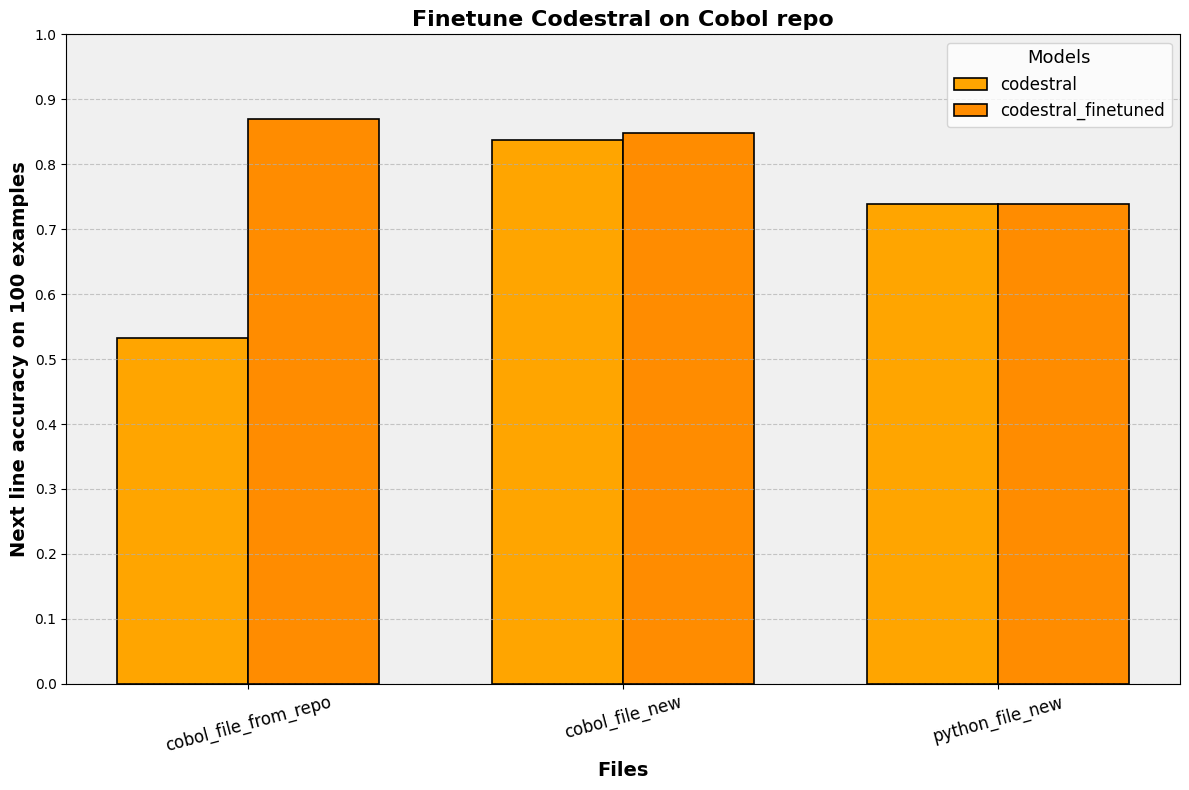

In [21]:
models = list(accuracies.keys())
files = list(accuracies['codestral'].keys())

# Prepare data for plotting
performance = {model: [accuracies[model][file] for file in files] for model in models}

# Bar width
bar_width = 0.35

# Positions for the bars
r = np.arange(len(files))

# Create the plot
plt.figure(figsize=(12, 8))  # Adjust the figure size here

colors = ['orange', 'darkorange']  # Colors for each model

for i, model in enumerate(models):
    plt.bar(r + i * bar_width, performance[model], width=bar_width, color=colors[i], label=model, edgecolor='black', linewidth=1.2)

# Add labels and title
plt.xlabel('Files', fontweight='bold', fontsize=14)
plt.ylabel(f'Next line accuracy on {num_examples} examples', fontweight='bold', fontsize=14)
plt.title('Finetune Codestral on Cobol repo', fontweight='bold', fontsize=16)
plt.xticks(r + bar_width / 2, files, fontsize=12, rotation=15)
plt.yticks(np.arange(0, 1.1, 0.1))  # Add more ticks on the y-axis

# Add a legend
plt.legend(title='Models', fontsize=12, title_fontsize=13)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a background color
plt.gca().set_facecolor('#f0f0f0')

# Show the plot
plt.tight_layout()
plt.show()